In [1]:
import os
os.chdir("..")
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import warnings
warnings.filterwarnings('ignore')

from src.amortized_inference.raycasting_trainer import RaycastingTrainer
from src.amortized_inference.raycasting_supervised_trainer import RaycastingSupervisedTrainer
from src.amortized_inference.config import default_config


def inference_on_data(res, tr, dataset, prefix="sim", n_sample=100, infer_type="mode", stride=1):
    progress_list = [0.8]
    acc_per_progress, prob_per_progress = list(), list()

    for progress in progress_list:
        gt_targets, gt_summ_data = dataset.sample_valid_data(fix_progress=progress, cross_fold_idx=tr.cross_fold_idx)
        n_param = gt_targets.shape[0]

        # normalized positions of target candidates
        target_info = gt_summ_data[0, 1:].reshape((-1, 3))

        map_arr, data_sz_arr = list(), list()
        acc_arr, prob_arr = list(), list()

        for param_i in range(0, n_param, stride):
            summ_i = gt_summ_data[param_i]
            data_sz_arr.append(1)

            # Unsqueeze (as 1-size batch)
            summ_i = np.expand_dims(summ_i, axis=0)

            # Get MAP fit
            map_fit = tr.amortizer.infer(summ_i, n_sample=n_sample, infer_type=infer_type).detach().numpy()
            map_arr.append(tr._clip_params(map_fit))

            # Fix the other fitted user parameters
            other_params = map_fit[3:]
            other_params = np.expand_dims(other_params, axis=0)
            other_params = np.repeat(other_params, target_info.shape[0], axis=0)
            candidates = np.concatenate([target_info, other_params], axis=-1)

            # Get the probability of the other candidates
            summs = np.repeat(summ_i, candidates.shape[0], axis=0)
            densities = tr.amortizer.pdf(candidates, summs) + 1e-30
            probabilities = densities / np.nansum(densities)
            max_target_i = np.argmax(probabilities)

            acc_arr.append(np.allclose(candidates[max_target_i, :3], gt_targets[param_i, :3], atol=1e-3))
            prob_arr.append(probabilities[max_target_i])

        map_arr = np.array(map_arr)
        data_sz_arr = np.array(data_sz_arr)
        acc_arr = np.array(acc_arr)
        prob_arr = np.array(prob_arr)
        acc_per_progress.append(acc_arr)
        prob_per_progress.append(prob_arr)

        res[f"acc_{prefix}_{progress*100:.0f}"] = acc_arr.mean()
        res[f"conf_{prefix}_{progress*100:.0f}"] = prob_arr.mean()


In [2]:
# Limiting the number of users
res_n_user = dict()
stride = 5

for n in [16, 8, 4, 2]:
    for k in [1, 2, 3, 4, 5]:
        config_temp = deepcopy(default_config)
        config_temp["n_train_user"] = -1 if n == 16 else n
        config_temp["n_trial_per_user"] = -1
        config_temp["cross_fold_idx"] = k

        name = f"{k}"
        if config_temp["n_train_user"] != -1:
            name += f"_{n}user"
            config_temp["name"] = f"limited_data/human_dense_{name}"
        else:
            config_temp["name"] = f"human_dense_{name}"

        trainer = RaycastingSupervisedTrainer(config=config_temp)
        trainer.load()
        trainer.amortizer.eval()
        inference_on_data(res_n_user, trainer, trainer.dataset, prefix=name, n_sample=100, infer_type="mode", stride=stride)

config_temp["name"] = "sim_dense"
sim_trainer = RaycastingTrainer()
sim_trainer.load()
sim_trainer.amortizer.eval()
sim_trainer.cross_fold_idx = -1
inference_on_data(res_n_user, sim_trainer, sim_trainer.user_dataset, prefix="sim", n_sample=100, infer_type="mode", stride=stride)


[ amortizer - loaded checkpoint ]
	/Users/hsmoon/Documents/GitHub/3d-target-inference/data/amortizer_models/human_dense_1/iter100.pt
[ amortizer - loaded checkpoint ]
	/Users/hsmoon/Documents/GitHub/3d-target-inference/data/amortizer_models/human_dense_2/iter100.pt
[ amortizer - loaded checkpoint ]
	/Users/hsmoon/Documents/GitHub/3d-target-inference/data/amortizer_models/human_dense_3/iter100.pt
[ amortizer - loaded checkpoint ]
	/Users/hsmoon/Documents/GitHub/3d-target-inference/data/amortizer_models/human_dense_4/iter100.pt
[ amortizer - loaded checkpoint ]
	/Users/hsmoon/Documents/GitHub/3d-target-inference/data/amortizer_models/human_dense_5/iter100.pt
[ amortizer - loaded checkpoint ]
	/Users/hsmoon/Documents/GitHub/3d-target-inference/data/amortizer_models/limited_data/human_dense_1_8user/iter100.pt
[ amortizer - loaded checkpoint ]
	/Users/hsmoon/Documents/GitHub/3d-target-inference/data/amortizer_models/limited_data/human_dense_2_8user/iter100.pt
[ amortizer - loaded checkpoint

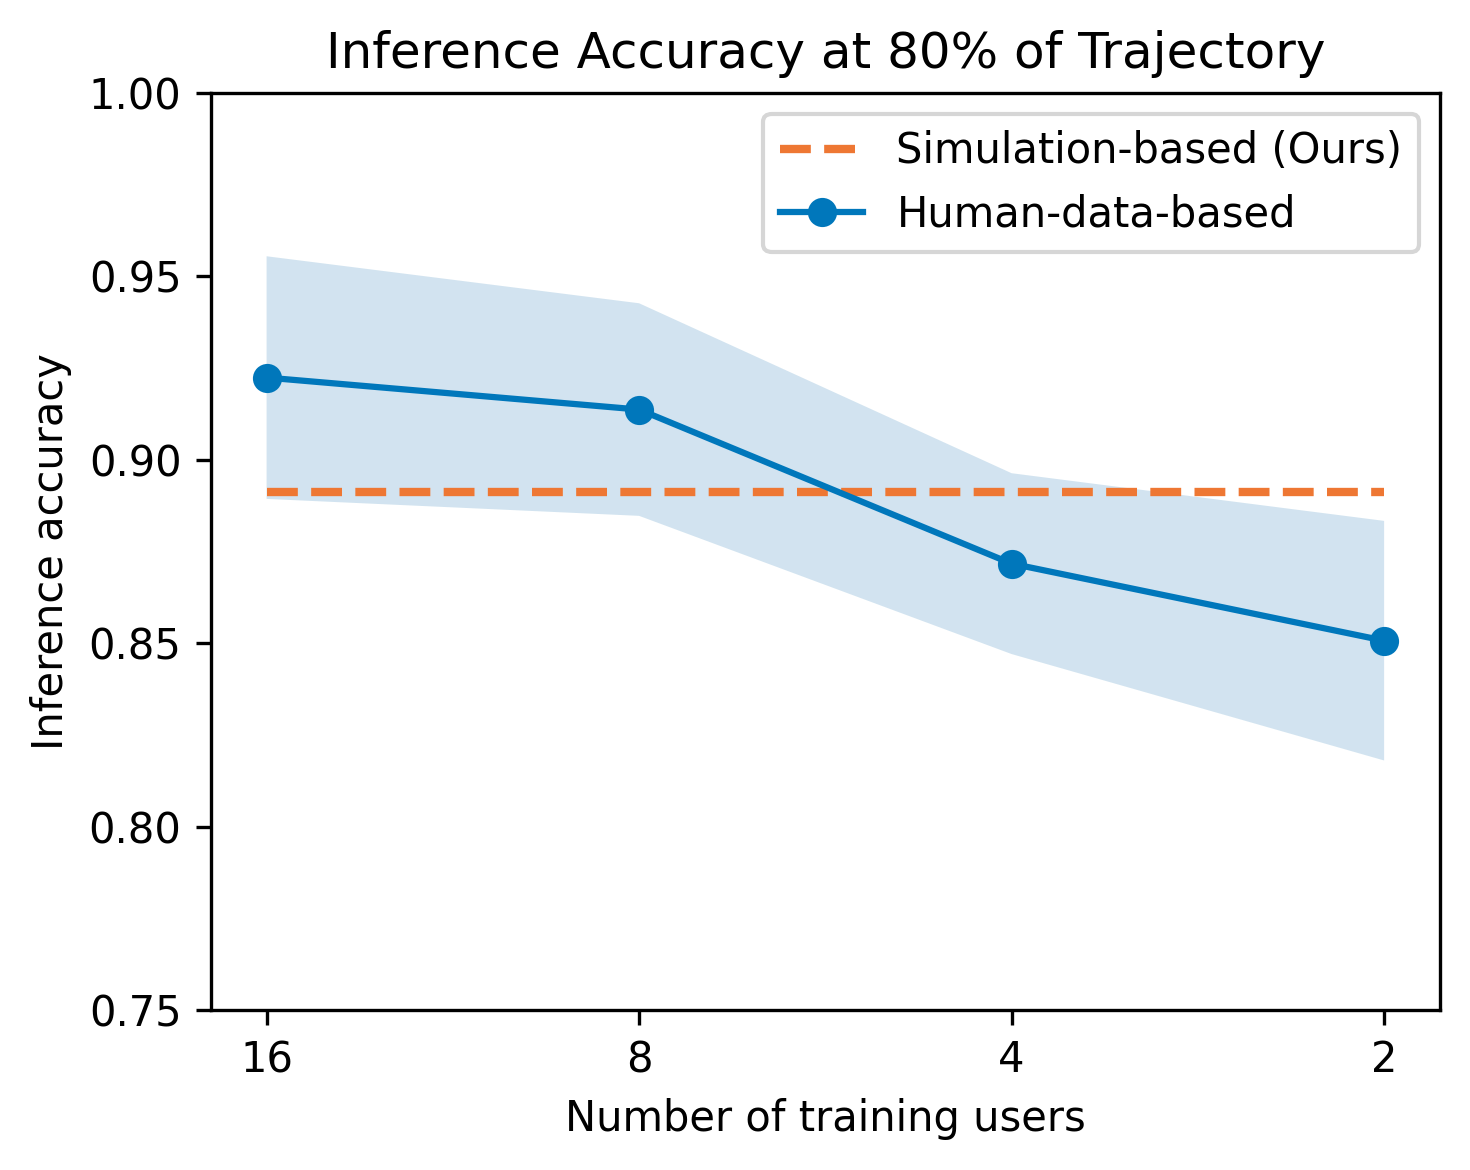

In [4]:
# Figure 9A: Inference accuracy per number of training users

n_user_acc_80 = list()
for n in [16, 8, 4, 2]:
    acc_temp = list()
    for k in [1, 2, 3, 4, 5]:
        acc_temp.append(res_n_user[f"acc_{k}_{n}user_80"] if n != 16 else res_n_user[f"acc_{k}_80"])
    n_user_acc_80.append(acc_temp)
n_user_acc_80 = np.array(n_user_acc_80)
sim_acc_80 = res_n_user["acc_sim_80"]

# plot the results (subplots for each progress)
import os
fig, ax = plt.figure(figsize=(5, 4), dpi=300), plt.gca()
ax.plot([1, 2, 3, 4], [sim_acc_80, sim_acc_80, sim_acc_80, sim_acc_80], linestyle="--", lw=2.0, color="#EE7733")
ax.plot([1, 2, 3, 4], n_user_acc_80.mean(axis=1), marker="o", color="#0077BB")
ax.fill_between(
    [1, 2, 3, 4], 
    n_user_acc_80.mean(axis=1)-n_user_acc_80.std(axis=1), 
    n_user_acc_80.mean(axis=1)+n_user_acc_80.std(axis=1), 
    alpha=0.2
)
ax.set_xlabel("Number of training users")
ax.set_ylabel("Inference accuracy")
ax.set_xticks([1, 2, 3, 4])
ax.set_xticklabels(["16", "8", "4", "2"])
ax.set_title(f"Inference Accuracy at 80% of Trajectory")
ax.legend(["Simulation-based (Ours)", "Human-data-based"])
ax.set_ylim([0.75, 1.0])
plt.tight_layout()
plt.savefig(os.path.join("./results/plots", f"study2_training_user.pdf"), dpi=300)
plt.show()

In [5]:
### limiting the number of trials (data size)
res_n_trial = dict()
stride = 5

for n in [128, 64, 32, 16]:
    for k in [1, 2, 3, 4, 5]:
        config_temp = deepcopy(default_config)
        config_temp["n_train_user"] = -1
        config_temp["n_trial_per_user"] = -1 if n == 256 else n
        config_temp["cross_fold_idx"] = k

        name = f"{k}"
        if config_temp["n_trial_per_user"] != -1:
            name += f"_{n}trial"
            config_temp["name"] = f"limited_data/human_dense_{name}"

        trainer = RaycastingSupervisedTrainer(config=config_temp)
        trainer.load()
        trainer.amortizer.eval()
        inference_on_data(res_n_trial, trainer, trainer.dataset, prefix=name, n_sample=100, infer_type="mode", stride=stride)


[ amortizer - loaded checkpoint ]
	/Users/hsmoon/Documents/GitHub/3d-target-inference/data/amortizer_models/limited_data/human_dense_1_128trial/iter100.pt
[ amortizer - loaded checkpoint ]
	/Users/hsmoon/Documents/GitHub/3d-target-inference/data/amortizer_models/limited_data/human_dense_2_128trial/iter100.pt
[ amortizer - loaded checkpoint ]
	/Users/hsmoon/Documents/GitHub/3d-target-inference/data/amortizer_models/limited_data/human_dense_3_128trial/iter100.pt
[ amortizer - loaded checkpoint ]
	/Users/hsmoon/Documents/GitHub/3d-target-inference/data/amortizer_models/limited_data/human_dense_4_128trial/iter100.pt
[ amortizer - loaded checkpoint ]
	/Users/hsmoon/Documents/GitHub/3d-target-inference/data/amortizer_models/limited_data/human_dense_5_128trial/iter100.pt
[ amortizer - loaded checkpoint ]
	/Users/hsmoon/Documents/GitHub/3d-target-inference/data/amortizer_models/limited_data/human_dense_1_64trial/iter100.pt
[ amortizer - loaded checkpoint ]
	/Users/hsmoon/Documents/GitHub/3d-ta

[[0.925      0.965      0.875      0.89714286 0.95      ]
 [0.92       0.96       0.91       0.88       0.945     ]
 [0.92       0.95       0.925      0.85714286 0.95      ]
 [0.87       0.94       0.865      0.87428571 0.905     ]
 [0.775      0.78       0.78       0.77714286 0.855     ]]


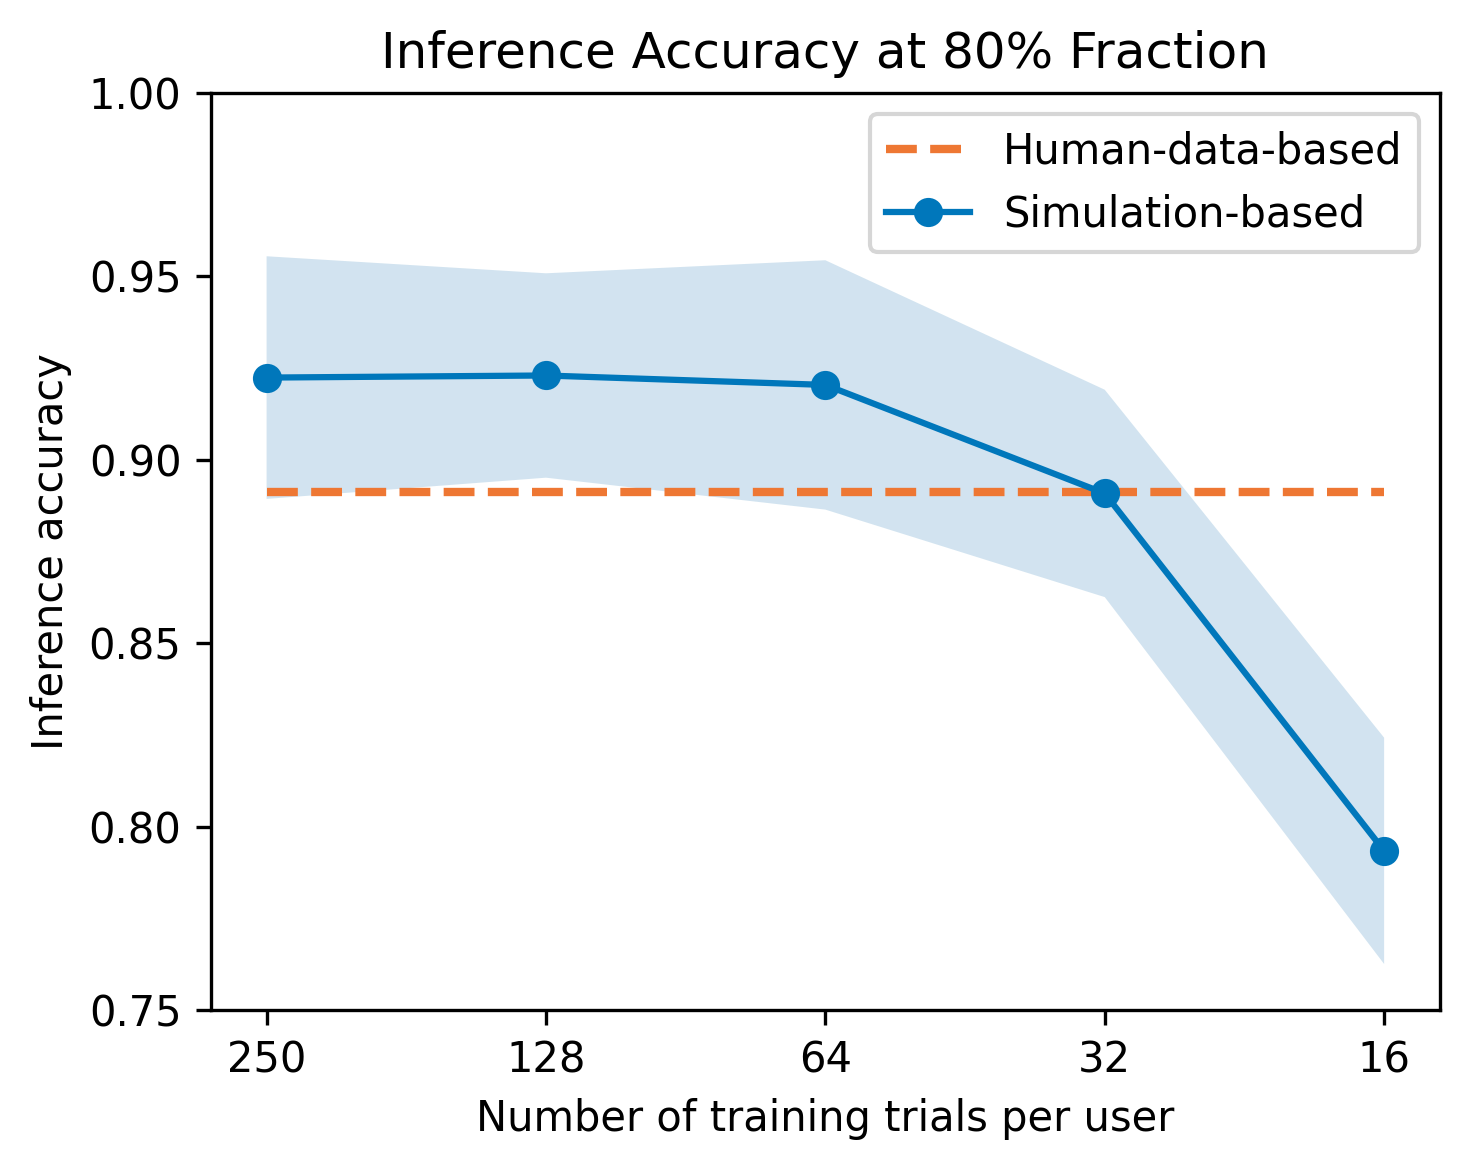

In [10]:
# Figure 9B: Inference accuracy per number of training trials

n_user_acc_80 = list()
for n in [250, 128, 64, 32, 16]:
    acc_temp = list()
    for k in [1, 2, 3, 4, 5]:
        acc_temp.append(res_n_trial[f"acc_{k}_{n}trial_80"] if n != 250 else res_n_user[f"acc_{k}_80"])
    n_user_acc_80.append(acc_temp)
n_user_acc_80 = np.array(n_user_acc_80)
sim_acc_80 = res_n_user["acc_sim_80"]

# plot the results (subplots for each progress)
import os
fig, ax = plt.figure(figsize=(5, 4), dpi=300), plt.gca()
ax.plot([1, 2, 3, 4, 5], [sim_acc_80, sim_acc_80, sim_acc_80, sim_acc_80, sim_acc_80], linestyle="--", lw=2.0, color="#EE7733")
ax.plot([1, 2, 3, 4, 5], n_user_acc_80.mean(axis=1), marker="o", color="#0077BB")
ax.fill_between(
    [1, 2, 3, 4, 5], 
    n_user_acc_80.mean(axis=1)-n_user_acc_80.std(axis=1), 
    n_user_acc_80.mean(axis=1)+n_user_acc_80.std(axis=1), 
    alpha=0.2
)
ax.set_xlabel("Number of training trials per user")
ax.set_ylabel("Inference accuracy")
ax.set_xticks([1, 2, 3, 4, 5])
ax.set_xticklabels(["250", "128", "64", "32", "16"])
ax.set_title(f"Inference Accuracy at 80% Fraction")
ax.legend(["Human-data-based", "Simulation-based"])
ax.set_ylim([0.75, 1.0])
plt.tight_layout()
plt.savefig(os.path.join("./results/plots", f"study2_training_trials.pdf"), dpi=300)
plt.show()